# 02_lag_analysis

In [ ]:
## Lagged Climate–Lassa Analysis

This notebook explores lagged relationships between climate variables
(rainfall and temperature) and weekly Lassa fever cases in Nigeria.

We test whether climate signals precede increases in cases, supporting
their use in early warning systems.

[saved] /Users/emmanuelbenyeogor/Projects/lassa-transmission-pipeline/reports/figures/fig1_pipeline_dag_refs.png


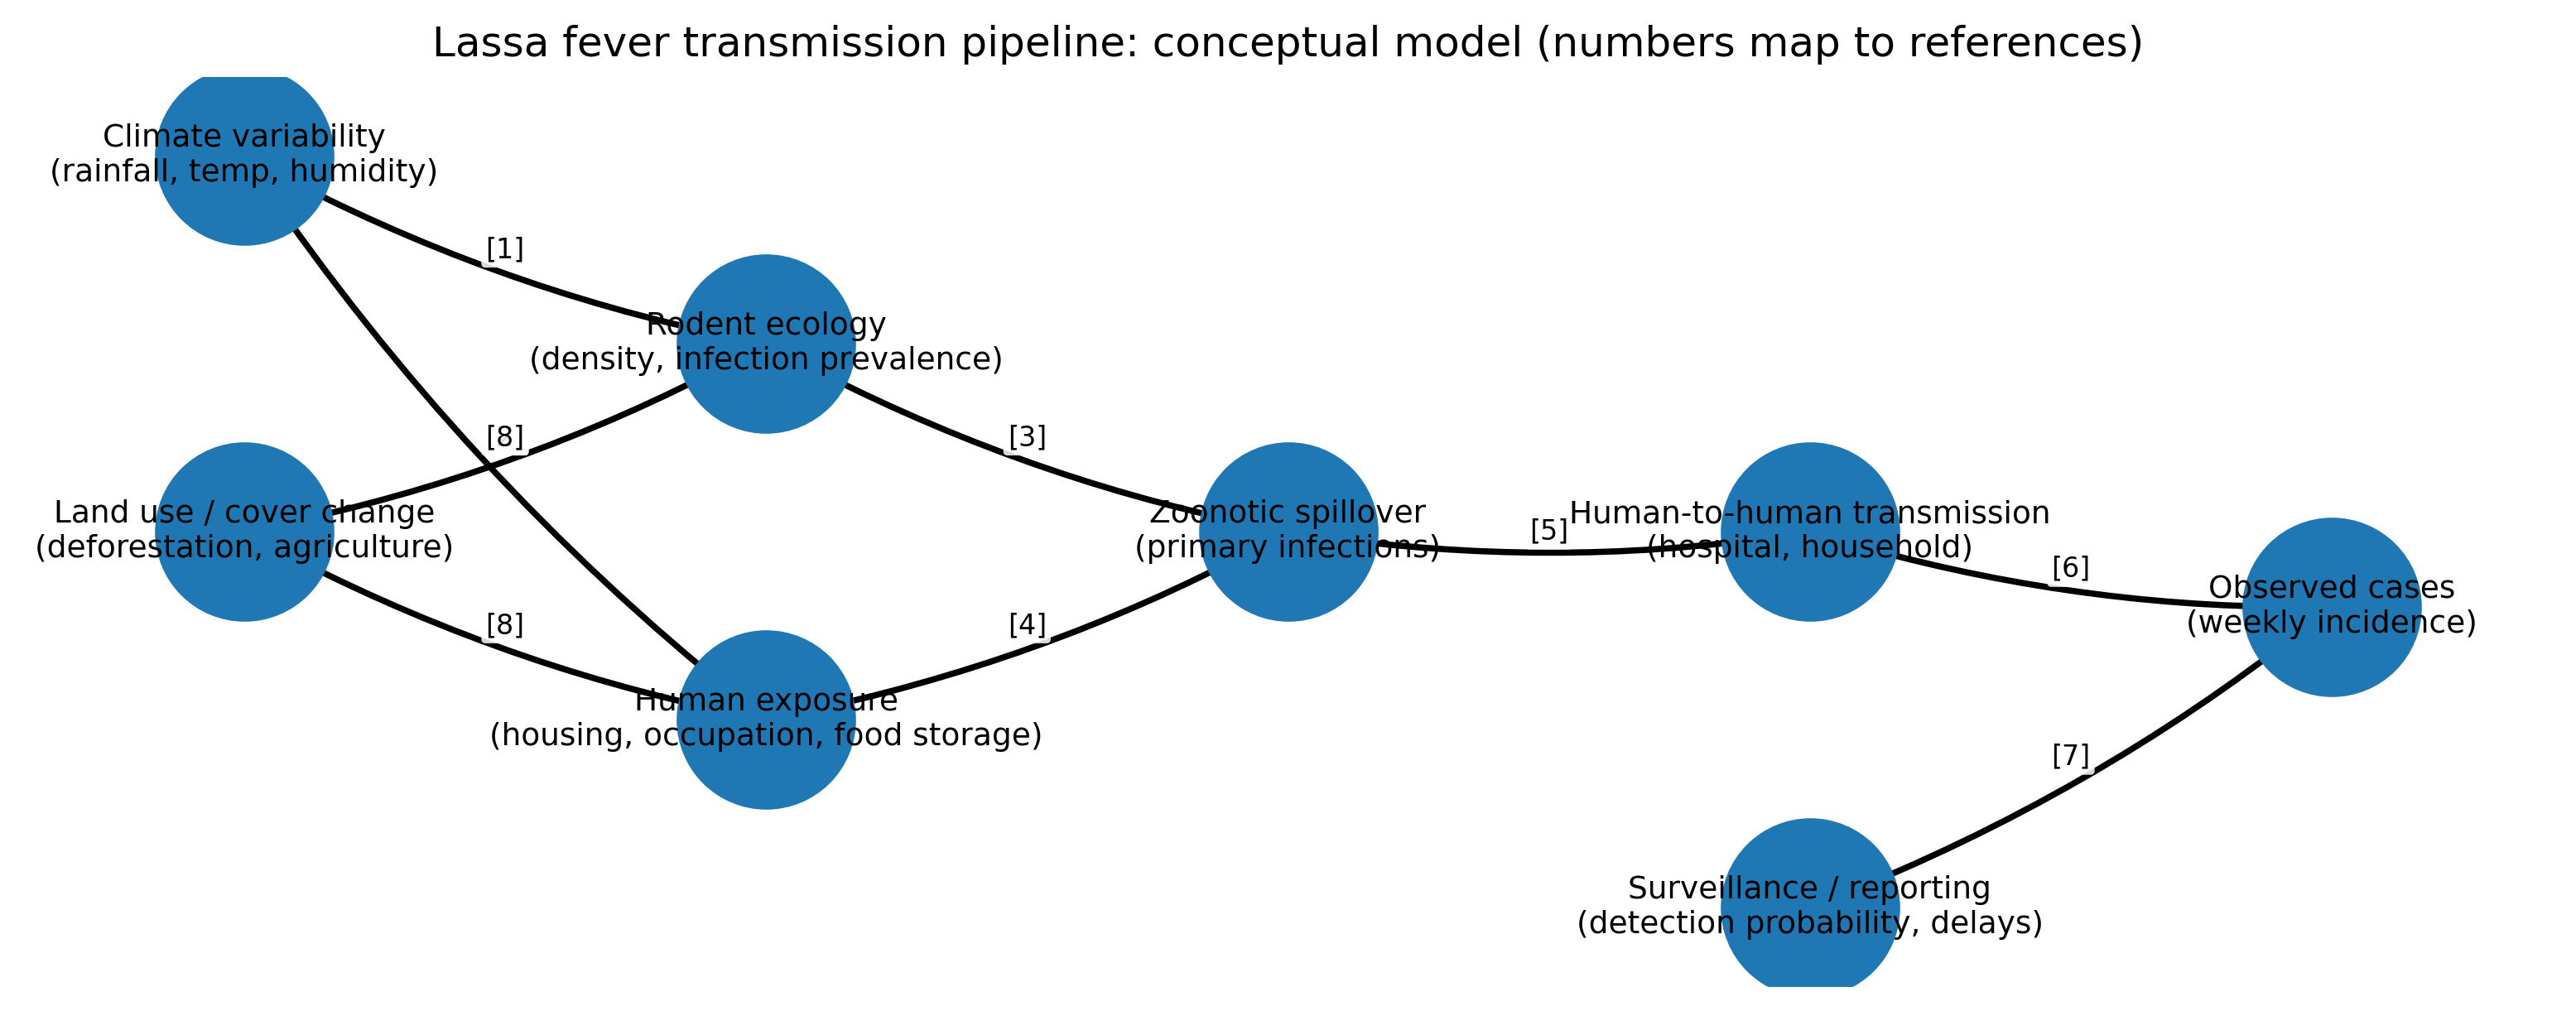

PosixPath('/Users/emmanuelbenyeogor/Projects/lassa-transmission-pipeline/reports/figures/fig1_pipeline_dag_refs.png')

In [2]:
# =========================================================
# FIXED: figures script (Figure 1 DAG with edge citations)
# =========================================================

from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Optional, Dict, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Optional for DAG
try:
    import networkx as nx
except ImportError:
    nx = None


@dataclass
class FigConfig:
    # FIX 1: repo-relative path (NOT absolute /reports/figures)
    outdir: Path = Path("reports/figures")
    dpi: int = 300
    fmt: str = "png"  # use "pdf" for vector output
    linewidth: float = 2.0
    fontsize: int = 11

    def ensure_outdir(self) -> None:
        self.outdir.mkdir(parents=True, exist_ok=True)


def set_mpl_style(cfg: FigConfig) -> None:
    plt.rcParams.update({
        "figure.dpi": cfg.dpi,
        "savefig.dpi": cfg.dpi,
        "font.size": cfg.fontsize,
        "axes.titlesize": cfg.fontsize + 1,
        "axes.labelsize": cfg.fontsize,
        "legend.fontsize": cfg.fontsize - 1,
        "xtick.labelsize": cfg.fontsize - 1,
        "ytick.labelsize": cfg.fontsize - 1,
        "axes.spines.top": False,
        "axes.spines.right": False,
        "lines.linewidth": cfg.linewidth,
    })


def save_fig(cfg: FigConfig, name: str, show: bool = True) -> Path:
    cfg.ensure_outdir()
    path = (cfg.outdir / f"{name}.{cfg.fmt}").resolve()
    plt.tight_layout()
    plt.savefig(path, bbox_inches="tight")
    print(f"[saved] {path}")
    if show:
        plt.show()
    plt.close()
    return path


def fig_pipeline_dag(cfg: FigConfig, name: str = "fig1_pipeline_dag_refs", show: bool = True) -> Path:
    """
    DAG schematic with automatic numbered citations placed on each arrow.

    Arrow → reference map (numbers shown on edges):
      [1] Climate -> Rodent
      [2] LandUse -> Rodent
      [3] Rodent -> Spillover
      [4] Contact -> Spillover
      [5] Spillover -> H2H
      [6] H2H -> Obs
      [7] Surv -> Obs
      [8] Climate -> Contact
      [8] LandUse -> Contact
    """
    if nx is None:
        raise ImportError("networkx is required for fig_pipeline_dag. Install with: pip install networkx")

    set_mpl_style(cfg)

    G = nx.DiGraph()

    nodes = [
        ("Climate", "Climate variability\n(rainfall, temp, humidity)"),
        ("LandUse", "Land use / cover change\n(deforestation, agriculture)"),
        ("Rodent", "Rodent ecology\n(density, infection prevalence)"),
        ("Contact", "Human exposure\n(housing, occupation, food storage)"),
        ("Spillover", "Zoonotic spillover\n(primary infections)"),
        ("H2H", "Human-to-human transmission\n(hospital, household)"),
        ("Surv", "Surveillance / reporting\n(detection probability, delays)"),
        ("Obs", "Observed cases\n(weekly incidence)"),
    ]
    for k, label in nodes:
        G.add_node(k, label=label)

    edges_with_refs = [
        ("Climate", "Rodent", 1),
        ("LandUse", "Rodent", 2),
        ("Rodent", "Spillover", 3),
        ("Contact", "Spillover", 4),
        ("Spillover", "H2H", 5),
        ("H2H", "Obs", 6),
        ("Surv", "Obs", 7),
        ("Climate", "Contact", 8),
        ("LandUse", "Contact", 8),
    ]
    G.add_edges_from([(u, v) for u, v, _ in edges_with_refs])

    pos = {
        "Climate": (0, 2),
        "LandUse": (0, 1),
        "Rodent": (2, 1.5),
        "Contact": (2, 0.5),
        "Spillover": (4, 1.0),
        "H2H": (6, 1.0),
        "Surv": (6, 0.0),
        "Obs": (8, 0.8),
    }

    plt.figure(figsize=(10.5, 4.2))
    labels = {k: v for k, v in nodes}

    nx.draw_networkx_nodes(G, pos, node_size=2600)
    nx.draw_networkx_edges(
        G, pos,
        arrows=True,
        arrowstyle="-|>",
        arrowsize=18,
        width=1.8,
        connectionstyle="arc3,rad=0.08",
    )
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=9)

    edge_labels = {(u, v): f"[{refno}]" for u, v, refno in edges_with_refs}
    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_size=8,
        label_pos=0.5,
        rotate=False,
        bbox=dict(boxstyle="round,pad=0.15", fc="white", ec="none", alpha=0.85),
    )

    plt.title("Lassa fever transmission pipeline: conceptual model (numbers map to references)")
    plt.axis("off")
    return save_fig(cfg, name, show=show)


# =========================================================
# RUN (this must be OUTSIDE the function)
# =========================================================
cfg = FigConfig(outdir=Path("../reports/figures"), fmt="png", dpi=300)
fig_pipeline_dag(cfg, show=True)
